James Ian V. Tiu
AP 155 Probset: Solutions to Problems 4.17, 4.18
September 23, 2025

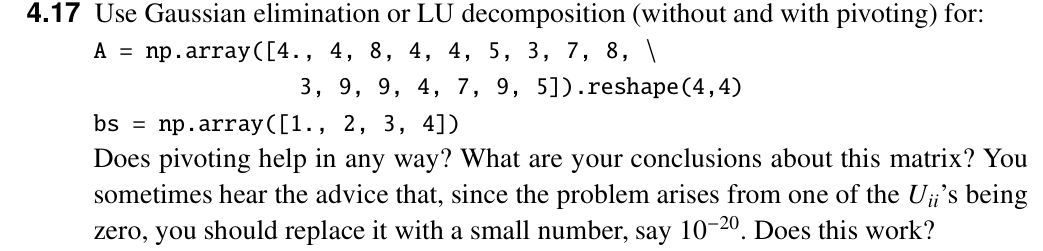

We first start with applying the algorithms from the book in its purest form:

In [4]:
import numpy as np
def forsub(L,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in range(n):
        xs[i] = (bs[i]- L[i,:i]@xs[:i])/L[i,i]
    return xs
def backsub(U,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in reversed(range(n)):
        xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]
    return xs
def testsolve(f,A,bs):
    xs = f(A,bs); print(xs)
    xs = np.linalg.solve(A,bs); print(xs)
def gauelim(inA,inbs):
    A = np.copy(inA)
    bs = np.copy(inbs)
    n = bs.size
    for j in range(n-1):
        for i in range(j+1,n):
            coeff = A[i,j]/A[j,j]
            A[i,j:]-= coeff*A[j,j:]
            bs[i]-= coeff*bs[j]
            xs = backsub(A,bs)
    return xs
def ludec(A):
    n = A.shape[0]
    U = np.copy(A)
    L = np.identity(n)
    for j in range(n-1):
        for i in range(j+1,n):
            coeff = U[i,j]/U[j,j]
            U[i,j:]-= coeff*U[j,j:]
            L[i,j] = coeff
    return L, U
def lusolve(A,bs):
    L, U = ludec(A)
    ys = forsub(L,bs)
    xs = backsub(U,ys)
    return xs

A = np.array([4., 4, 8, 4, 4, 5,3, 7, 8, \
 3, 9,9, 4, 7,9, 5]).reshape(4,4)
bs = np.array([1., 2, 3, 4])
print(testsolve(gauelim,A,bs))
print(testsolve(lusolve,A,bs))

[nan nan inf inf]
[-2.62268449e+16 -8.74228163e+15  8.74228163e+15  1.74845633e+16]
None
[nan nan inf inf]
[-2.62268449e+16 -8.74228163e+15  8.74228163e+15  1.74845633e+16]
None


C:\Users\James\AppData\Local\Temp\ipykernel_39364\1994177790.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]
C:\Users\James\AppData\Local\Temp\ipykernel_39364\1994177790.py:12: RuntimeWarning: invalid value encountered in matmul
  xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]


Well that's a travesty. With pivoting the solution shows:

In [6]:
def gauelim_pivot(inA,inbs):
    A = np.copy(inA)
    bs = np.copy(inbs)
    n = bs.size
    for j in range(n-1):
        k = np.argmax(np.abs(A[j:,j])) + j
        if k != j:
            A[j,:], A[k,:] = A[k,:], A[j,:].copy()
            bs[j], bs[k] = bs[k], bs[j]
            
        for i in range(j+1,n):
            coeff = A[i,j]/A[j,j]
            A[i,j:]-= coeff*A[j,j:]
            bs[i]-= coeff*bs[j]
    xs = backsub(A,bs)
    return xs

print(testsolve(gauelim_pivot,A,bs))

[ nan  inf -inf -inf]
[-2.62268449e+16 -8.74228163e+15  8.74228163e+15  1.74845633e+16]
None


C:\Users\James\AppData\Local\Temp\ipykernel_39364\1994177790.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]
C:\Users\James\AppData\Local\Temp\ipykernel_39364\1994177790.py:12: RuntimeWarning: invalid value encountered in matmul
  xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]


Okay. It turns out we still encounter the error even with partial pivoting, which is supposed to erase the problem of encountering a random 0 in a diagonal element during the elimination. Alright, since the book showcases some magic can happen with replacing 0s by 10^(-20), a "really small number", we now redefine the forsub and backsub operations to avoid any division by zero:

In [8]:
def forsub(L,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in range(n):
        if L[i,i] == 0:
            L[i,i] = 10**(-20)
    for i in range(n):
        xs[i] = (bs[i]- L[i,:i]@xs[:i])/L[i,i]
    return xs
def backsub(U,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in range(n):
        if U[i,i] == 0:
            U[i,i] = 10**(-20)
    for i in reversed(range(n)):
        xs[i] = (bs[i]- U[i,i+1:]@xs[i+1:])/U[i,i]
    return xs

print(testsolve(gauelim_pivot,A,bs))

[ 3.e+20  1.e+20 -1.e+20 -2.e+20]
[-2.62268449e+16 -8.74228163e+15  8.74228163e+15  1.74845633e+16]
None


We finally have a real solution! The code works! The solution is still far from what np.linalg.solve() offers, but at least we have something. Or do we? Actually here replacing any 0 with a really small number didn't work at all in our favor as we're about to see.

What's fishy that hasn't been noted up to this point is that np.linalg.solve() outputs an unfathomably high-valued solution, even when the matrices A and be look simple. This raises the suspicion that something's not quite right with the linear system of equations. Indeed, when we try to solve the system by hand, we realize that the system actually has no solutions:
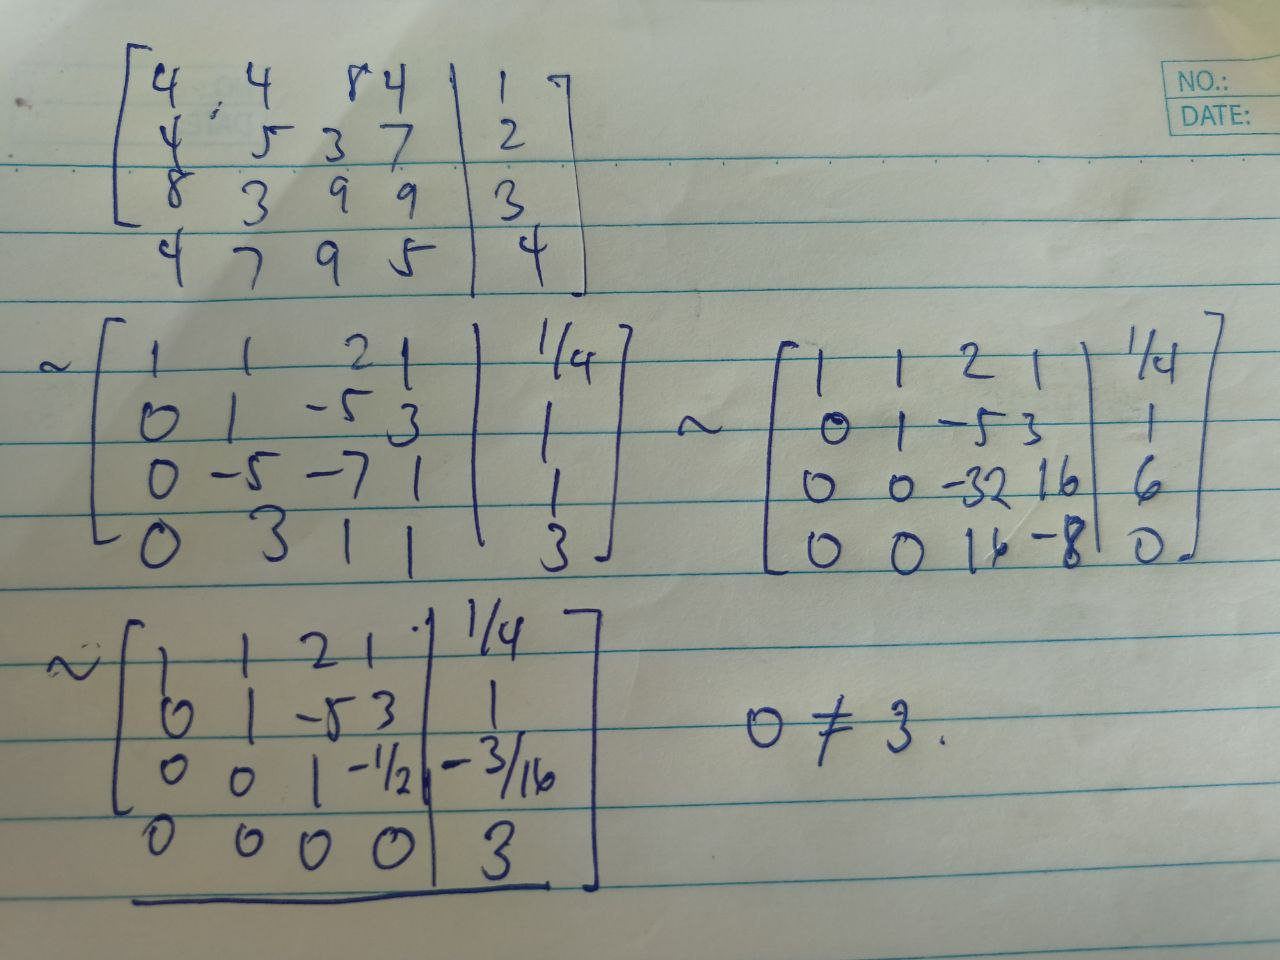

One might wonder, if there was actually no solution to the linear system, why didn't np.linalg.solve ever warn us of anything? A thought immediately comes from the fact that the solution of np.linalg.solve and the 10^(-20) solution both are factors of a base matrix [3, 1, -1, -2]. I assume that np.linalg.solve also implements something similar to what we did with the 0s from earlier in order to avoid any hard errors.

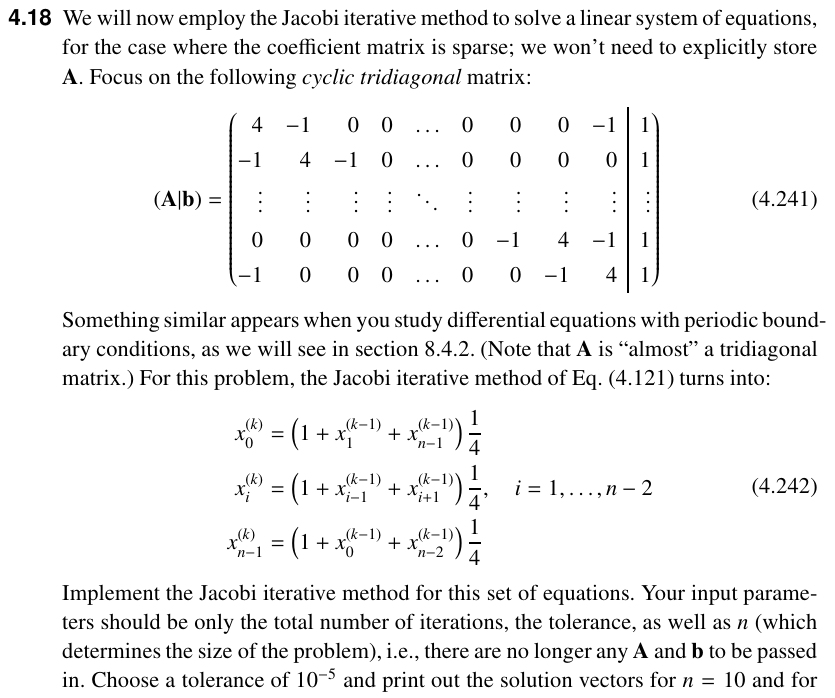

In [11]:
def termcrit(xolds,xnews): #Code 4.5 modified
    errs = np.abs((xnews- xolds)/xnews)
    return np.sum(errs)
def jacobi(kmax, tol, n): 
    xnews = np.zeros(n)
    for k in range(1,kmax):
        xs = np.copy(xnews)
        for i in range(n):
            slt = xs[i-1]
            sgt = xs[i]
            xnews[i] = (1 + slt + sgt)/4
        err = termcrit(xs, xnews)
        if err < tol:
            break
    else:
        xnews = None
        
    return xnews

def A(n): #generating A explicitly for np.linalg.solve().
    matrix = np.zeros((n,n)).tolist()
    for i in range(n):
        matrix[i][i]= 4
        if 0 < i < n-1:
            matrix[i][i+1] = matrix[i][i-1] = -1
        elif i == 0:
            matrix[0][n-1] = matrix[0][1] = -1
        else:
            matrix[n-1][0] = matrix[n-1][n-2] = -1
    return np.array(matrix)
    
def be(n):
    return np.ones(n)

print(jacobi(100, 1e-5, 10))
print(np.linalg.solve(A(10), be(10)))
print(jacobi(100, 1e-5, 20))
print(np.linalg.solve(A(20), be(20)))


[0.49999952 0.49999952 0.49999952 0.49999952 0.49999952 0.49999952
 0.49999952 0.49999952 0.49999952 0.49999952]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.49999976 0.49999976 0.49999976 0.49999976 0.49999976 0.49999976
 0.49999976 0.49999976 0.49999976 0.49999976 0.49999976 0.49999976
 0.49999976 0.49999976 0.49999976 0.49999976 0.49999976 0.49999976
 0.49999976 0.49999976]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]


We see values that are close enough to the solution provided by np.linalg.solve(), but not quite there. If we choose a smaller tolerance we get closer to the values we want:

In [13]:
print(jacobi(100, 1e-6, 10))
print(np.linalg.solve(A(10), be(10)))
print(jacobi(100, 1e-6, 20))
print(np.linalg.solve(A(20), be(20)))

[0.49999997 0.49999997 0.49999997 0.49999997 0.49999997 0.49999997
 0.49999997 0.49999997 0.49999997 0.49999997]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.49999999 0.49999999 0.49999999 0.49999999 0.49999999 0.49999999
 0.49999999 0.49999999 0.49999999 0.49999999 0.49999999 0.49999999
 0.49999999 0.49999999 0.49999999 0.49999999 0.49999999 0.49999999
 0.49999999 0.49999999]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]
